In [1]:
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline


In [2]:
words=open("names.txt",'r').read().splitlines()
chars=sorted(list(set(''.join(words))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
vocab_size=len(itos)
vocab_size

27

In [3]:
import random   
random.seed(42) 
random.shuffle(words)

In [210]:
block_size=8 

def build_dataset(words):
    x,y=[],[]

    for w in words:
        context=[0]*block_size 
        for ch in w + '.':
            ix=stoi[ch]
            x.append(context)
            y.append(ix)
            context=context[1:]+[ix]
    x=torch.tensor(x)
    y=torch.tensor(y)
    print(x.shape,y.shape)
    return (x,y)

n1=int(len(words)*0.8)
n2=int(len(words)*0.9)
xtr,ytr=build_dataset(words[:n1])
xdev,ydev=build_dataset(words[n1:n2])
xtest,ytest=build_dataset(words[n2:])


torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [211]:
for x,y in zip(xtr[:20],ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x),"-->",itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [333]:
class Linear:
    def __init__(self,fan_in,fan_out,bias=True):
        self.weight=torch.randn((fan_in,fan_out),generator=g)/fan_in**0.5
        self.bias=torch.randn((fan_out)) if bias else None
    def __call__(self,x):
        self.out=x@self.weight
        if self.bias is not None:
            self.out+=self.bias 
        return self.out 
    def parameters(self):
        return [self.weight]+([] if self.bias is None else [self.bias])

class BatchNorm1d:
    
    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps=eps 
        self.momentum=momentum 
        self.training=True 

        self.gamma=torch.ones(dim)
        self.beta=torch.zeros(dim) 

        self.running_mean=torch.zeros(dim)
        self.running_var=torch.ones(dim)

    def __call__(self,x):
        if self.training:
            if x.ndim==2:
                dim=0
            elif x.ndim==3:
                dim=(0,1)
            xmean=x.mean(dim,keepdim=True)
            xvar=x.var(dim,keepdim=True)
        else:
            xmean=self.running_mean 
            xvar=self.running_var 
        xhat=(x-xmean)/torch.sqrt(xvar+self.eps)
        self.out=self.gamma*xhat+self.beta 
        if self.training:
            with torch.no_grad():
                self.running_mean=(1-self.momentum)*self.running_mean+self.momentum*xmean
                self.running_var=(1-self.momentum)*self.running_var+self.momentum*xvar 
        return self.out 
    
    def parameters(self):
        return [self.gamma,self.beta]
    
class Tanh:
    def __call__(self,x):
        self.out=torch.tanh(x)
        return self.out 
    def parameters(self):
        return []

class Embedding:
    def __init__(self,num_embeddings,embedding_dim):
        self.weight=torch.randn((num_embeddings,embedding_dim)) 
    def __call__(self,IX):
        self.out=self.weight[IX]
        return self.out 
    def parameters(self):
        return [self.weight]

class Flattenconsecutive:
    def __init__(self,n):
        self.n=n
    def __call__(self,x):
        B,T,C=x.shape
        x=x.view(B,T//self.n,C*self.n)
        if x.shape[1]==1:
            x=x.squeeze()
        self.out=x
        return self.out
    def parameters(self):
        return []

class Sequential:
    def __init__(self,layers):
        self.layers=layers
    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        self.out=x 
        return self.out
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]        




In [334]:
n_embd=10 
n_hidden=68
g=torch.Generator().manual_seed(2147483647)
C=torch.randn((vocab_size,n_embd), generator=g)

model=Sequential([
        Embedding(vocab_size,n_embd),
        Flattenconsecutive(2),Linear(n_embd*2,n_hidden,bias=False), BatchNorm1d(n_hidden),Tanh(),
        Flattenconsecutive(2),Linear(n_hidden*2,n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(),
        Flattenconsecutive(2),Linear(n_hidden*2,n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden,vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight*=0.1 


parameters=model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True 


    

22397


In [335]:
max_steps=200000
batch_size=32
lossi=[]
ud=[]

for i in range(max_steps):
    ix=torch.randint(0,xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb=xtr[ix],ytr[ix]
    
    #forward pass 
    logits=model(Xb)      
    loss=F.cross_entropy(logits,Yb)
    
    # backward pass 
    for p in parameters:
        p.grad=None 
    loss.backward()
    
    # update 
    lr=0.1 if i <150000 else 0.01 
    for p in parameters:
        p.data+=-lr * p.grad 

    if i %10000 ==0: 
        print(f'{i:7d}/{max_steps:7d}: {loss.item(): .4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std()/p.data.std()).log10().item() for p in parameters])
    
    # if i >=1000:
    #     break

      0/ 200000:  3.6357
  10000/ 200000:  2.2786
  20000/ 200000:  1.9830
  30000/ 200000:  2.0436
  40000/ 200000:  2.3736
  50000/ 200000:  1.9124
  60000/ 200000:  1.7396
  70000/ 200000:  1.9126
  80000/ 200000:  1.8565
  90000/ 200000:  2.1791
 100000/ 200000:  1.9584
 110000/ 200000:  2.1970
 120000/ 200000:  1.9724
 130000/ 200000:  2.1749
 140000/ 200000:  1.8355
 150000/ 200000:  1.6351
 160000/ 200000:  1.9229
 170000/ 200000:  1.7515
 180000/ 200000:  1.8184
 190000/ 200000:  1.9645


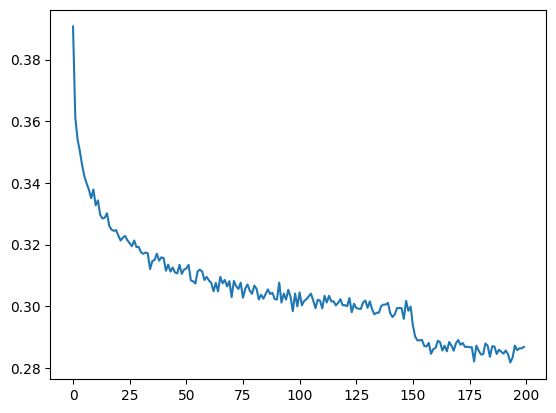

In [336]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [337]:
for layer in model.layers:
    layer.training=False

In [338]:
@torch.no_grad() 
def split_loss(split):
    x,y={
        'train':(xtr,ytr),
        'val':(xdev,ydev),
        'test':(xtest,ytest),
    }[split]
    
    
    logits=model(x)
    loss=F.cross_entropy(logits,y)
    print(split,loss.item())


split_loss('train')
split_loss('val')
    

train 1.9112673997879028
val 2.0200703144073486


In [341]:
g = torch.Generator().manual_seed(2147483647 + 2)
for _ in range(20):
    out=[]
    context=[0]*block_size 
    while True:
        x=[torch.tensor([context])]
        logits=model(x)
        probs=F.softmax(logits,dim=1)
        ix=torch.multinomial(probs,num_samples=1,generator=g).item()
        context=context[1:]+[ix] 
        out.append(ix)
        if ix==0:
            break 
    print(''.join(itos[i] for i in out))


lylinn.
siahla.
ari.
raka.
siren.
kamreig.
chrise.
sade.
kashtin.
maibrayl.
teovelype.
eibhnis.
millah.
ariena.
emmad.
jurrin.
amyiah.
oluwa.
kayan.
delmara.


In [238]:
e=torch.randn(4,8,2)


In [235]:
torch.cat([e[:,::2,:],e[:,1::2,:]],dim=2).shape

torch.Size([4, 4, 20])

In [320]:
e.ndim

3

In [306]:
for layer in model.layers:
    print(layer.out.shape)

torch.Size([32, 8, 10])
torch.Size([32, 4, 20])
torch.Size([32, 4, 100])
torch.Size([32, 4, 100])
torch.Size([32, 4, 100])
torch.Size([32, 2, 200])
torch.Size([32, 2, 100])
torch.Size([32, 2, 100])
torch.Size([32, 2, 100])
torch.Size([32, 200])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 27])
